# Hands-on session Wednesday 15
# Membership determination in open clusters using DBSCAN

This notebook is designed to guide you step by step through the development of the mini-project by following each cell. In some cases, **specific tasks are highlighted in bold** for you to complete. You can review the provided solutions to compare your results.



### Introduction to Gaia and Open Clusters

In this notebook we will use Gaia data from Data Release 3 (DR3) to obtain information from 2 open clusters in the Milky Way, and we will attempt to determine the true members of the clusters.

### What is Gaia?
Gaia is a space observatory launched by the European Space Agency (ESA) to chart a three-dimensional map of the Milky Way.
 - It provides precise astrometric, photometric, and spectroscopic data for over 1.8 billion sources.
 - Gaia Data Release 3 (DR3) includes information such as:
   - Positions (RA, DEC)
   - Proper motions
   - Parallaxes (distance indicators)
   - Radial velocities

### What are Open Clusters?
 - Open clusters are groups of stars that formed from the same molecular cloud and are gravitationally bound. They are the young stellar population in the Galactic Disk
 - They are key to understanding stellar evolution and the structure of the Milky Way.
 - Identifying membership of stars in open clusters is crucial for determining cluster properties like age, distance, and metallicity.




### **Part 1: Gaia and `astroquery`**

We need to install the libraries we will use to retrieve the data from Gaia Server. This is done with the module [`astroquery`](https://astroquery.readthedocs.io/en/latest/), which  is a set of tools for querying astronomical web forms and databases. We can write a query in SQL language

In [32]:
#you might need to install this
!pip install astroquery

In [50]:
#other important libraries

from math import *
import numpy as np
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia #to connect to the Gaia Catalog
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

The language used to query astronomical databases is **ADQL** (Astronomical Data Query Language), which is based on [SQL](https://www.dataquest.io/blog/sql-basics/) (Structured Query Language).

- For more information on ADQL, you can refer to this [link](https://www.gaia.ac.uk/data/gaia-data-release-1/adql-cookbook).


The Gaia database is a **structured database**, meaning it is a collection of one or more tables where data is organized into columns. These tables contain different types of information, such as positions, parallaxes, proper motions, magnitudes, and more. To explore the tables in the Gaia database, we can query the database to retrieve a list of available tables and their descriptions.

In [51]:
tables_gaia=Gaia.load_tables(only_names=True)

INFO:astroquery:Retrieving tables...


INFO: Retrieving tables... [astroquery.utils.tap.core]


INFO:astroquery:Parsing tables...


INFO: Parsing tables... [astroquery.utils.tap.core]


INFO:astroquery:Done.


INFO: Done. [astroquery.utils.tap.core]


In [52]:
#to check the names of the tables
for table in tables_gaia:
    print(table.name)

external.apassdr9
external.catwise2020
external.gaiadr2_astrophysical_parameters
external.gaiadr2_geometric_distance
external.gaiaedr3_distance
external.gaiaedr3_gcns_main_1
external.gaiaedr3_gcns_rejected_1
external.gaiaedr3_spurious
external.gaia_eso_survey
external.galex_ais
external.lamost_dr9_lrs
external.lamost_dr9_mrs
external.ravedr5_com
external.ravedr5_dr5
external.ravedr5_gra
external.ravedr5_on
external.ravedr6
external.sdssdr13_photoprimary
external.skymapperdr1_master
external.skymapperdr2_master
external.tmass_xsc
external.xgboost_table1
external.xgboost_table2
gaiadr1.aux_qso_icrf2_match
gaiadr1.ext_phot_zero_point
gaiadr1.allwise_best_neighbour
gaiadr1.allwise_neighbourhood
gaiadr1.gsc23_best_neighbour
gaiadr1.gsc23_neighbourhood
gaiadr1.ppmxl_best_neighbour
gaiadr1.ppmxl_neighbourhood
gaiadr1.sdss_dr9_best_neighbour
gaiadr1.sdss_dr9_neighbourhood
gaiadr1.tmass_best_neighbour
gaiadr1.tmass_neighbourhood
gaiadr1.ucac4_best_neighbour
gaiadr1.ucac4_neighbourhood
gaiadr1.u

We need to load the DR3 database

In [53]:
table_metadata = Gaia.load_table('gaiadr3.gaia_source')
table_metadata

In [54]:
print(table_metadata) #check the metadata

TAP Table name: gaiadr3.gaiadr3.gaia_source
Description: This table has an entry for every Gaia observed source as published with this data release. It contains the basic source parameters, in their final state as processed by the Gaia Data Processing and Analysis Consortium from the raw data coming from the spacecraft. The table is complemented with others containing information specific to certain kinds of objects (e.g.~Solar--system objects, non--single stars, variables etc.) and value--added processing (e.g.~astrophysical parameters etc.). Further array data types (spectra, epoch measurements) are presented separately via Datalink resources.
Num. columns: 152


In [55]:
#check the columns
for column in table_metadata.columns:
    print(column.name)

solution_id
designation
source_id
random_index
ref_epoch
ra
ra_error
dec
dec_error
parallax
parallax_error
parallax_over_error
pm
pmra
pmra_error
pmdec
pmdec_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
astrometric_n_obs_al
astrometric_n_obs_ac
astrometric_n_good_obs_al
astrometric_n_bad_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_primary_flag
nu_eff_used_in_astrometry
pseudocolour
pseudocolour_error
ra_pseudocolour_corr
dec_pseudocolour_corr
parallax_pseudocolour_corr
pmra_pseudocolour_corr
pmdec_pseudocolour_corr
astrometric_matched_transits
visibility_periods_used
astrometric_sigma5d_max
matched_transits
new_matched_transits
matched_transits_removed
ipd_gof_harmonic_amplitude
ipd_gof_harmonic_phase
ipd_frac_multi_peak
ipd_frac_odd_win
ruwe
scan_direction_strength_k1
scan_di

This table contains **152 columns** and includes all objects observed by Gaia, making it a very large dataset. However, we do not need all objects; instead, we are interested in a subset of objects relevant to our research goals. To address this, we will use **ADQL** to write a query in SQL that helps us extract only the data we need.

In this case we will retrieve:
- **source_id:** id of the source
- **ra, dec**: position in the sky right ascension, declination (J2000)
- **parallax**: parallax angle. Parallax is the measurement of the angular displacement of a star as seen from Earth at opposite points in its orbit around the Sun (six months apart). It is directly related to the distance to the star, through the formula:
$$ d\rm{(parsec)} = \frac{1}{p\rm{(arcsec)}}$$
 where: $d$ is the distance to the star in parsecs and $p$ is the parallax angle in arcseconds.
- **pm, pmra, pmdec** proper motions, absolute and in RA, DEC
- **phot_g_mean_mag, bp_rp** photometric information in Gaia passbands, filters $G$, $G_{BP}$ and $G_RP$

<img src="https://www.cosmos.esa.int/documents/29201/4226701/GaiaEDR3_ExtPhotSystem.png/b1633feb-7929-16e9-afc3-b9a5afdb5311?t=1603981069444" alt="Gaia passbands" width="500">

In [56]:
table_metadata = Gaia.load_table('gaiadr3.gaia_source')
for column in table_metadata.columns:
    print(column.name)

solution_id
designation
source_id
random_index
ref_epoch
ra
ra_error
dec
dec_error
parallax
parallax_error
parallax_over_error
pm
pmra
pmra_error
pmdec
pmdec_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
astrometric_n_obs_al
astrometric_n_obs_ac
astrometric_n_good_obs_al
astrometric_n_bad_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_primary_flag
nu_eff_used_in_astrometry
pseudocolour
pseudocolour_error
ra_pseudocolour_corr
dec_pseudocolour_corr
parallax_pseudocolour_corr
pmra_pseudocolour_corr
pmdec_pseudocolour_corr
astrometric_matched_transits
visibility_periods_used
astrometric_sigma5d_max
matched_transits
new_matched_transits
matched_transits_removed
ipd_gof_harmonic_amplitude
ipd_gof_harmonic_phase
ipd_frac_multi_peak
ipd_frac_odd_win
ruwe
scan_direction_strength_k1
scan_di

To select objects within a specific region of the sky, we can perform a **cone search** using `astroquery` and specific operators in [ADQL](https://www.ivoa.net/documents/ADQL/20180112/PR-ADQL-2.1-20180112.html#tth_sEc4.2.12).


In this case, we will analyse the cluster M41 (NGC 2287).


<img src="https://noirlab.edu/public/media/archives/images/large/noao-m41.jpg" alt="NGC2287" width="500">



We will perform the cone search centered in the cluster coordinates and  in a radius of 45 arcmin, which contains the size of the cluster reported in the literature. The basic information of the cluster can be found in the [SIMBAD database](https://simbad.cds.unistra.fr/simbad/sim-id?Ident=ngc+2287&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id).

Since the cone search requires the input information in degrees, we use the function `SkyCoord`in the `astropy` module to transform the units from arcmin to degrees.

(This is a simple calculation, since
- 1 degree (1° ) is 1/360 of a complete circle.
- 1 arcminute = 1/60 of a degree
- 1 arcsecond = 1/60 of a minute = 1/3600 of a degree

In the case of right ascension and hours, each hour of right ascension measured along the equator equals 1/24th of a circle (360° divided by 24) or 15°)

In [57]:
#hh:m:s y dd:m:s a deg
print(SkyCoord('06h 45m 59.8s', '-20d 42m 58s', frame='icrs'))

radius_open= 45* u.arcmin
print(radius_open)

radius_open.to(u.degree)

<SkyCoord (ICRS): (ra, dec) in deg
    (101.49916667, -20.71611111)>
45.0 arcmin


<Quantity 0.75 deg>

the query of the cone search is then

In [58]:
query_open= """SELECT
TOP 30000
source_id, ra, dec, phot_g_mean_mag, parallax, bp_rp,  pm, pmra, pmdec
FROM gaiadr3.gaia_source
WHERE 1=CONTAINS(
  POINT(ra, dec),
  CIRCLE(101.49916667, -20.71611111, 0.66333333)) AND parallax > 0
"""

In [59]:
job_open= Gaia.launch_job_async(query_open)
results_open = job_open.get_results()
results_open

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


SOURCE_ID,ra,dec,phot_g_mean_mag,parallax,bp_rp,pm,pmra,pmdec
,deg,deg,mag,mas,mag,mas / yr,mas / yr,mas / yr
int64,float64,float64,float32,float64,float32,float32,float64,float64
2927221938248097664,101.00826728029993,-20.413492093618338,19.126757,1.2279430882203777,2.3177261,13.95697,-10.287167910343673,9.432453672912503
2927247540550651776,101.71179304876829,-20.16021289560781,19.767414,0.29620940937264306,1.035986,1.395708,-0.44038889504568807,1.3244086739412981
2927207816396619904,101.42956421640929,-20.57671247051978,18.565006,0.282729920551078,1.5901337,4.243958,-0.5562094405351562,4.207352136274502
2927207816396621312,101.43434877839267,-20.573418291446004,19.084236,0.13027360271977734,1.1447735,1.4800311,-0.7331574917721514,1.2856796213319923
2927207820699071744,101.42556399835148,-20.573399442330285,17.78727,0.22110976967688278,1.1333637,0.91023487,-0.08197273400692548,0.906536239144099
2927207820699071872,101.42832221542523,-20.575767199416987,19.427097,0.31004839979712595,1.2941608,1.9071779,-0.7901731975620963,1.7357862995128137
2927207850756363264,101.44158926016136,-20.56670664875881,17.29901,0.18936470479074924,0.9805622,1.5348289,0.056147712836880484,1.5338015760835826
2927207850756365440,101.43484253433132,-20.5630687507806,20.01941,0.17632308607323044,1.0519772,1.6121466,0.07532080021342599,1.6103861164200939


We limit the number of sources to 30000 with `TOP 30000`in the query. Also, the parallax must be a positive number, since negative parallax is a error in the observation ([link](https://www.cosmos.esa.int/web/gaia-users/archive/faq#negative%20parallax))

The result is an astropy table (try `type(results_open)` to check). This table is similar to a dataframe, but includes more data from the columns. You can still transform the results to a more familiar `pandas` dataframe by using `.to_pandas()` function


In [60]:
type(results_open)

astropy.table.table.Table

In [131]:
cluster_data_df=results_open.to_pandas()

### **Part 2: Explore the data!**

A fundamental part in a machine learning process is to explore and to understand the data. First, we will visualize a well-known plot in astronomy, the **color-magnitude diagram (CMD)**. In this plot,the x-axis represents the **color** of the star, which is a measure of its temperature (e.g., (B-V), ($G_{BP}$ - $G_{RP}$)). The y-axis represents the **magnitude** (brightness), typically absolute or apparent magnitude.
An example of a CMD is the following:

<img src="https://d2vlcm61l7u1fs.cloudfront.net/media%2Facb%2Facb006e4-c478-4e25-bfb3-557f49655b3a%2FphpsTiIHV.png" alt="Simple CMD" width="500">

Note that the y-axis is [inverted](https://www.e-education.psu.edu/astro801/content/l4_p5.html#:~:text=If%20you%20notice%2C%20the%20magnitude,a%206th%20magnitude%20star.). Greater number in magnitude means more faint. This CMD represents all the stellar population of a particular clusters. All the stars have (more or less) the same age and were born from the same parent cloud. The different state of evolution is driven by the mass of each star

**Now plot the color-magnitude diagram of the selected cluster. x-axis must include the color bp_rp ($G_{bp}- G_{rp}$) and y-axis, the inverted magnitude (either phot_g_mean_mag, or the other two). Compare with the plot example above**

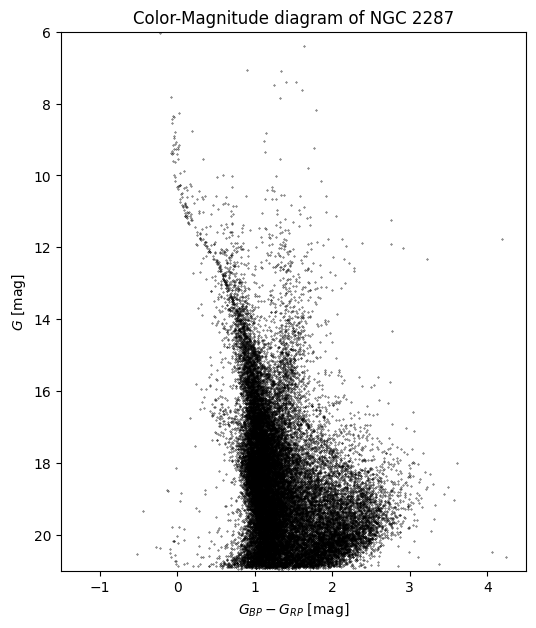

In [135]:
#plot figure
plt.figure(figsize=(6, 7))
plt.scatter(cluster_data_df['bp_rp'], cluster_data_df['phot_g_mean_mag'], s=0.1, c='k')
plt.xlim(-1.5, 4.5)
plt.ylim(6,21)
plt.title('Color-Magnitude diagram of NGC 2287')
plt.xlabel('$G_{BP}-G_{RP}$ [mag]')
plt.ylabel('$G$ [mag]')
plt.gca().invert_yaxis()

The plot is very noisy, compared to the previous one. This is because only the cluster population follows the sequence shown in the previous plot, and all the noise are non-members. We must get rid of these to clean de CMD

**We need to explore the other features in the data. Explore and visualize the distribution of parallax (remember that parallax is a representation of distance), and pmra and pmdec. Also, plot pmra vs pmdec. Remember that in the [SIMBAD](https://simbad.cds.unistra.fr/simbad/sim-id?Ident=ngc+2287&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id) webpage there is the information of the cluster, check the literature values of the proper motion and distance or parallax, and try to limit your axis in the figures accordingly.**

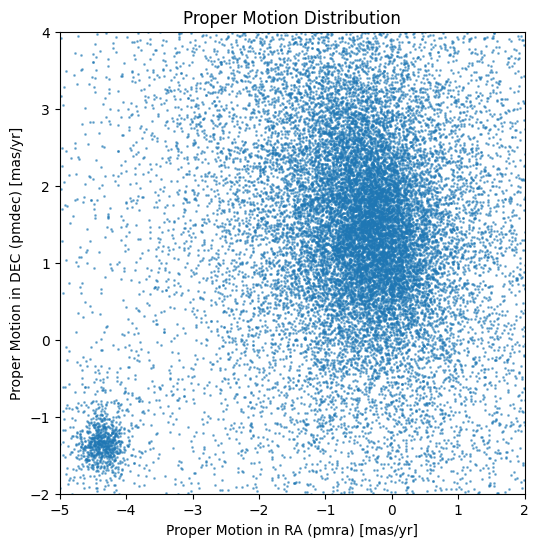

In [63]:
# Scatter plot of proper motions
plt.figure(figsize=(6, 6))
plt.scatter(cluster_data_df['pmra'], cluster_data_df['pmdec'], s=1, alpha=0.5)
plt.xlabel('Proper Motion in RA (pmra) [mas/yr]')
plt.ylabel('Proper Motion in DEC (pmdec) [mas/yr]')
plt.title('Proper Motion Distribution')
plt.xlim(-5,2)
plt.ylim(-2,4)
plt.show()

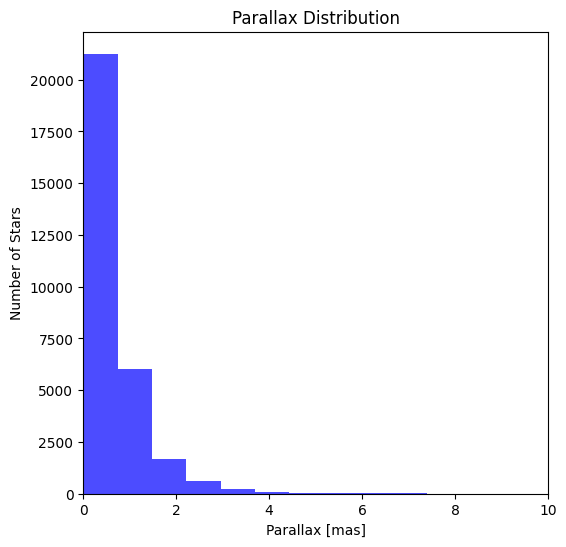

In [64]:
# Histogram of parallaxes
plt.figure(figsize=(6, 6))
plt.hist(cluster_data_df['parallax'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Parallax [mas]')
plt.ylabel('Number of Stars')
plt.title('Parallax Distribution')
plt.xlim(0,10)
plt.show()


Proper motion refers to the apparent motion of a star across the sky as observed from Earth, measured in milliarcseconds per year (mas/yr). **What do you think should be the proper motion of all the stars in the cluster??**


**ANSWER**: all stars in the cluster have the same proper motion

### **Part 3:** Unsupervised learning with DBSCAN

#### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN is a density-based clustering algorithm that groups points close to each other while marking points in low-density regions as noise.

- **Key Features:**
  - Does not require specifying the number of clusters beforehand.
  - Identifies clusters of arbitrary shapes.
  - Handles noise (outliers) effectively.

- **Parameters:**
  - **`eps`:** The maximum distance between two points for them to be considered neighbors.
  - **`min_samples`:** The minimum number of points required to form a dense region (a cluster).


Clusters are built recursively from core points connected by nearby neighbors, while points in low-density areas are identified as outliers. This makes DBSCAN particularly useful for data where clusters are not globular or convex and where there is noise or isolated points.

During each iteration of DBSCAN, the algorithm selects a point and evaluates whether it has enough neighbors within a distance `eps` to be considered a core point. If it qualifies as a core point, the cluster expands to include all its direct neighbors and their core neighbors recursively. If the point does not have enough neighbors, it is marked as a potential outlier. This process continues until all points are classified into clusters or labeled as outliers.

A nice visualization of DBSCAN can be found [here](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)

**We will use DBSCAN with some features (variables) from the data we retrieve to try to identify the cluster members from the background sources, based on the fact that cluster stars would be ‘clustered’ not only spatially, but also in parameter space.**

**Which variables do you think are important to separate the cluster members??**

In this notebook, as a first attempt, we will use proper motion and parallax

Before appliying DBSCAN, we need to make some preprocessing to the data. The algorithm uses distance (euclidean) to determine the density. This means that we need to scale the data, in this case, `pmra`, `pmdec`and `parallax`. Normalize the data to ensure equal weight for all features.


**Select from the table `pmra`, `pmdec`and `parallax` and apply [`StandardScaler()`](https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.StandardScaler.html), which will remove the mean and scale to the unit variance.**

In [45]:
from sklearn.preprocessing import StandardScaler


In [116]:
features = cluster_data_df[['pmra', 'pmdec', 'parallax']]


In [117]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

Now, implement DBSCAN algorithm. Remember the two parameters you must determine. For now, you can do it by "guessing" (for now). Plot again the `pmra` vs `pmdec` for each of the cluster members

In [ ]:
from sklearn.cluster import DBSCAN


In [118]:
dbscan = DBSCAN(eps=1, min_samples=10)  # choose the values of eps and min_samples
cluster_data_df['cluster'] = dbscan.fit_predict(scaled_features)

# Check the resulting clusters
print(cluster_data_df['cluster'].value_counts())


cluster
 0    29629
-1      360
 1       11
Name: count, dtype: int64


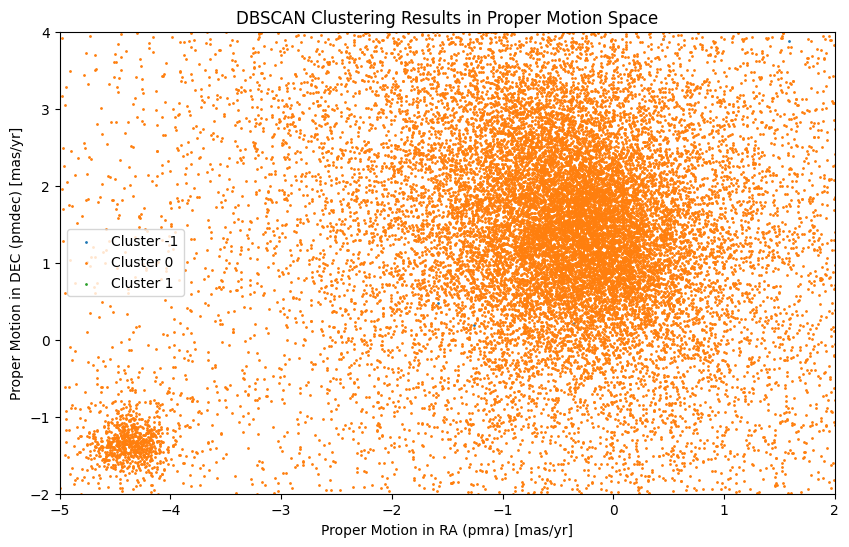

In [119]:
plt.figure(figsize=(10, 6))
for cluster_id in np.unique(cluster_data_df['cluster']):
    cluster_members = cluster_data_df[cluster_data_df['cluster'] == cluster_id]
    plt.scatter(cluster_members['pmra'], cluster_members['pmdec'], s=1, label=f'Cluster {cluster_id}')

plt.xlabel('Proper Motion in RA (pmra) [mas/yr]')
plt.ylabel('Proper Motion in DEC (pmdec) [mas/yr]')
plt.title('DBSCAN Clustering Results in Proper Motion Space')
plt.legend()
plt.xlim(-5,2)
plt.ylim(-2,4)
plt.show()

**What do you think of your result? Were you able to separate the two distinct cluster in the proper motion space?**

To improve the results, we need to choose appropiate values of the parameters. One way to do it for `eps` is the k-distance plot, which is a visualization of the distance to the k-th nearest neighbor for all points in the dataset.

**How It Works:**
1. For each point in the dataset, calculate the distance to its k-th nearest neighbor (where  $k = \rm{min\_samples}$).
2. Sort these distances in ascending order and plot them.
3. Look for the **"elbow"** in the plot:
   - The elbow point represents a natural threshold where the slope of the curve changes significantly.
   - This point corresponds to a suitable value for `eps`.


We use the [`NearestNeighbors`](https://scikit-learn.org/1.6/modules/neighbors.html) function from scikit-learn


In [68]:
from sklearn.neighbors import NearestNeighbors


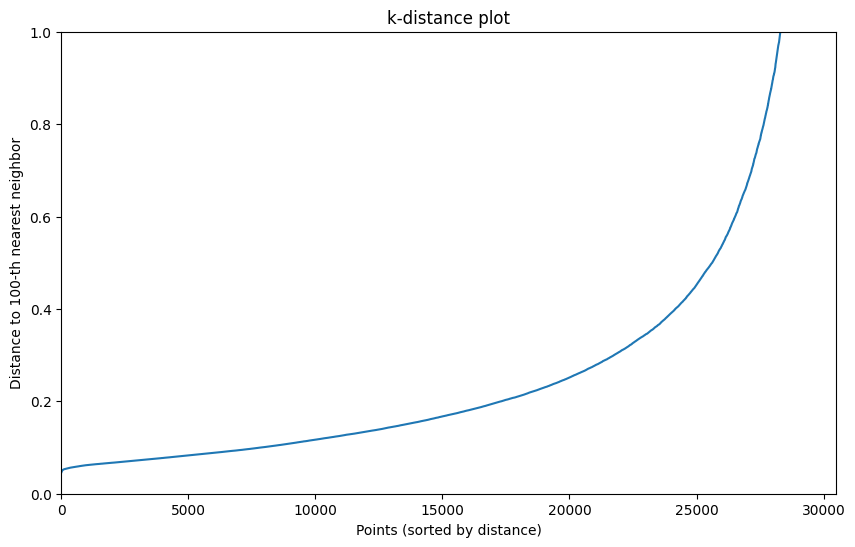

In [109]:
# Compute the k-nearest neighbors
k = 10  # explore what happens if you change this
nearest_neighbors = NearestNeighbors(n_neighbors=k)
nearest_neighbors.fit(scaled_features)
distances, _ = nearest_neighbors.kneighbors(scaled_features)

# Sort distances to find the elbow
distances = np.sort(distances[:, k-1])
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel("Points (sorted by distance)")
plt.ylabel(f"Distance to {k}-th nearest neighbor")
plt.title("k-distance plot")
plt.xlim(0,30500)
plt.ylim(0,1)
plt.show()

**Choose `eps` at the "elbow" point where the slope changes significantly. Points below this cutoff form dense clusters, while points above it are likely noise**

**Now, retry DBSCAN with your selected `min_samples` and `eps`parameters and check how it looks in the proper motion space**

In [136]:
dbscan = DBSCAN(eps=0.2, min_samples=100)  # Adjust eps based on k-distance plot
cluster_data_df['cluster'] = dbscan.fit_predict(scaled_features)

# Check the resulting clusters
print(cluster_data_df['cluster'].value_counts())


cluster
 0    19286
-1     9968
 1      746
Name: count, dtype: int64


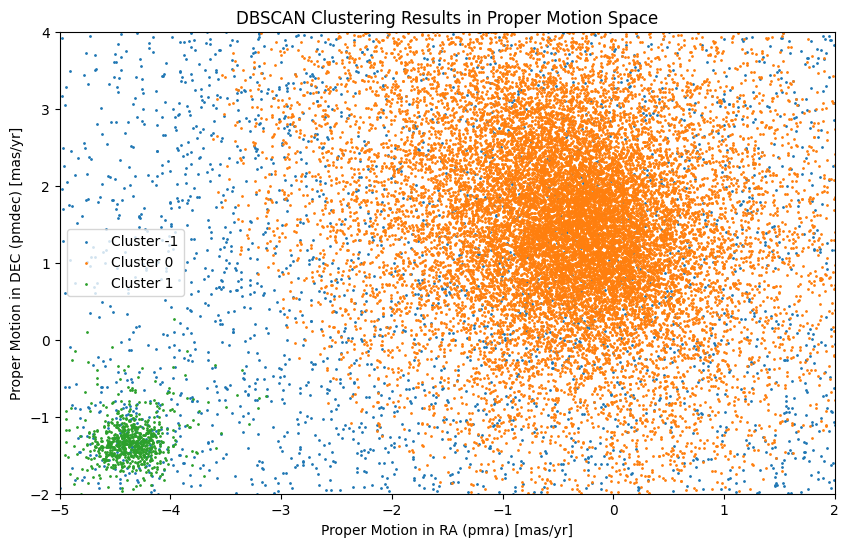

In [137]:
plt.figure(figsize=(10, 6))
for cluster_id in np.unique(cluster_data_df['cluster']):
    cluster_members = cluster_data_df[cluster_data_df['cluster'] == cluster_id]
    plt.scatter(cluster_members['pmra'], cluster_members['pmdec'], s=1, label=f'Cluster {cluster_id}')

plt.xlabel('Proper Motion in RA (pmra) [mas/yr]')
plt.ylabel('Proper Motion in DEC (pmdec) [mas/yr]')
plt.title('DBSCAN Clustering Results in Proper Motion Space')
plt.legend()
plt.xlim(-5,2)
plt.ylim(-2,4)
plt.show()

**Using the results, the next step is to plot the CMD exclusively for the cluster members identified by DBSCAN. This will allow us to evaluate whether the CMD more accurately represents the cluster population. Create a CMD plot focusing only on the identified cluster members.**

In [138]:
cluster_data_df.cluster.value_counts()

,count
cluster,
0,19286
-1,9968
1,746


In [139]:
cluster_members_dbscan=cluster_data_df[cluster_data_df['cluster']==1]

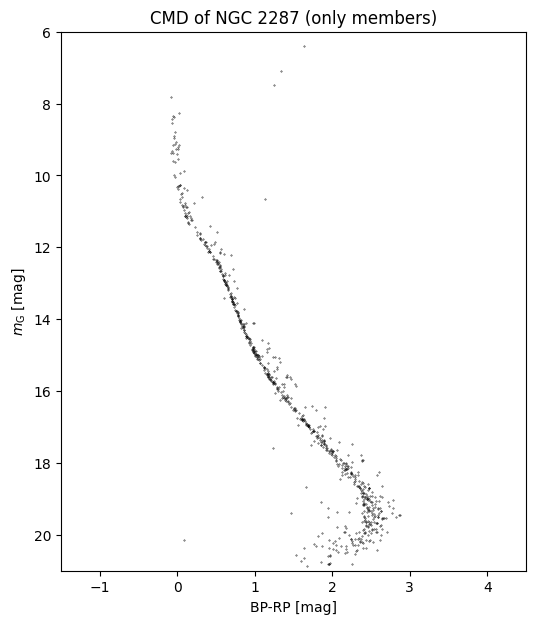

In [140]:
#plot figure
plt.figure(figsize=(6, 7))
plt.scatter(cluster_members_dbscan['bp_rp'], cluster_members_dbscan['phot_g_mean_mag'], s=0.1, c='k')
plt.xlim(-1.5, 4.5)
plt.ylim(6,21)
plt.title('CMD of NGC 2287 (only members)')
plt.xlabel('BP-RP [mag]')
plt.ylabel(r'$m_{\mathrm{G}}$ [mag]')
plt.gca().invert_yaxis()

**Questions**
- **What do you think can improve the method?**
- **What if we use other variables from the data (photometry, position, or other characteristics)?**
- **You can try your ideas with other clusters, such as NGC 2264, NGC 2682, NGC 2244, NGC 3293, NGC 6913, NGC 7142, IC 1805, NGC 6231, NGC 2243, NGC 6451, NGC 6005 and NGC 6583. (Pro tip: search the main characteristics in SINBAD to retrieve the data from Gaia). Select your favorite one and have fun!**


Some useful references


- Raja, M., Hasan, P., Mahmudunnobe, M., Saifuddin, M., & Hasan, S. N. (2024). Membership determination in open clusters using the DBSCAN Clustering Algorithm. arXiv, 2404.10477. Retrieved from https://arxiv.org/abs/2404.10477v1

- Gao, X. (2024). A clustering (DBSCAN+GMM) investigation of the young open cluster NGC 6649. Mon. Not. R. Astron. Soc., 527(2), 1784–1793. doi: 10.1093/mnras/stad3358

- Badawy, W. A., Tadross, A. L., Hendy, Y. H. M., Hassan, I. A., Ismail, M. N., & Mouner, A. (2022). Open clusters with proper motions fully separatedfrom the field stars using Gaia DR2. NRIAG J. Astron. Geophys. doi: 10.1080/20909977.2022.2037817